# Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer


import json
%matplotlib inline

#Plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

### Helper visualise functions @Laura Lewis

In [2]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=82)
    plt.show()

## Loading Data

In [3]:
df = pd.read_csv('data/listings.csv')

# Set max width for column
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', None)

# Display truncated version of column
df.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,71609,https://www.airbnb.com/roo...,20221229070856,2022-12-29,city scrape,Ensuite Room (Room 1 & 2) ...,For 3 rooms.Book room 1&2 ...,NaN,https://a0.muscache.com/pi...,367042,https://www.airbnb.com/use...,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Hou...,within a few hours,90%,100%,f,https://a0.muscache.com/im...,https://a0.muscache.com/im...,Tampines,6,15,"['email', 'phone']",t,t,NaN,Tampines,East Region,1.34537,103.95887,Private room in villa,Private room,6,NaN,1 private bath,2.0,3.0,"[""Cooking basics"", ""Refrig...","$46,437.00",92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,NaN,t,0,0,0,242,2022-12-29,20,0,0,2011-12-19,2020-01-17,4.44,4.37,4.00,4.63,4.78,4.26,4.32,NaN,f,6,0,6,0,0.15
1,71896,https://www.airbnb.com/roo...,20221229070856,2022-12-29,city scrape,B&B Room 1 near Airport &...,<b>The space</b><br />Voca...,NaN,https://a0.muscache.com/pi...,367042,https://www.airbnb.com/use...,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Hou...,within a few hours,90%,100%,f,https://a0.muscache.com/im...,https://a0.muscache.com/im...,Tampines,6,15,"['email', 'phone']",t,t,NaN,Tampines,East Region,1.34754,103.95958,Private room in home,Private room,1,NaN,Shared half-bath,1.0,1.0,"[""Cooking basics"", ""Refrig...",$81.00,92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,NaN,t,0,0,0,242,2022-12-29,24,0,0,2011-07-30,2019-10-13,4.16,4.22,4.09,4.43,4.43,4.17,4.04,NaN,t,6,0,6,0,0.17
2,71903,https://www.airbnb.com/roo...,20221229070856,2022-12-29,city scrape,Room 2-near Airport & EXPO,"Like your own home, 24hrs ...",Quiet and view of the play...,https://a0.muscache.com/pi...,367042,https://www.airbnb.com/use...,Belinda,2011-01-29,Singapore,Hi My name is Belinda -Hou...,within a few hours,90%,100%,f,https://a0.muscache.com/im...,https://a0.muscache.com/im...,Tampines,6,15,"['email', 'phone']",t,t,"Singapore, Singapore",Tampines,East Region,1.34531,103.96100,Private room in home,Private room,2,NaN,Shared half-bath,1.0,2.0,"[""Cooking basics"", ""Heatin...",$81.00,92,1125,92.0,92.0,1125.0,1125.0,92.0,1125.0,NaN,t,30,33,33,305,2022-12-29,47,0,0,2011-05-04,2020-01-09,4.41,4.39,4.52,4.63,4.64,4.50,4.36,NaN,f,6,0,6,0,0.33
3,275343,https://www.airbnb.com/roo...,20221229070856,2022-12-29,city scrape,Amazing Room with window 1...,Awesome location and host ...,NaN,https://a0.muscache.com/pi...,1439258,https://www.airbnb.com/use...,Kay,2011-11-24,Singapore,K2 Guesthouse is designed ...,within an hour,100%,85%,f,https://a0.muscache.com/im...,https://a0.muscache.com/im...,Bukit Merah,46,59,"['email', 'phone']",t,t,NaN,Bukit Merah,Central Region,1.29015,103.80814,Private room in rental unit,Private room,1,NaN,NaN,1.0,1.0,"[""Air conditioning"", ""

In [4]:
print("Data type:", type(df))
print("Data dimensions: ", df.shape) #3037 rows and 75 columns 

Data type: <class 'pandas.core.frame.DataFrame'>
Data dimensions:  (3037, 75)


## Drop unnecessary columns

Columns that do not add any useful information can be removed.

In [5]:
# Only keep important columns
drop_cols = ['id','listing_url','scrape_id','last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_response_time', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'bathrooms_text', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
df.drop(columns=drop_cols, axis=1, inplace=True)

## Dealing with missing data

In [6]:
missing_count = df.isnull().sum()
missing_percent = df.isnull().mean()
concatenated = pd.concat([missing_count,missing_percent], axis=1)
concatenated.columns = ['Count for Missing Value ','%']
display(concatenated)

,Count for Missing Value,%
host_since,0,0.000000
host_response_rate,619,0.203820
neighbourhood_cleansed,0,0.000000
neighbourhood_group_cleansed,0,0.000000
latitude,0,0.000000
longitude,0,0.000000
property_type,0,0.000000
room_type,0,0.000000
accommodates,0,0.000000
bathrooms,3037,1.000000


In [7]:
temp = list(df.isna().sum())

lst= []
i=0
for col in df.columns:
    insert_lst = [col,temp[i]]
    lst.append(insert_lst)
    i+=1

#Create a dataframe
temp_df = pd.DataFrame(data=lst,columns=['Column_Name','Missing_Values'])

fig = px.bar(temp_df.sort_values(by='Missing_Values'),x='Missing_Values',y='Column_Name',
             orientation='h',height=1000,width=1050,color='Missing_Values',text='Missing_Values',title='Missing values in train dataset')
fig.update_traces(textposition='outside')
fig.show()

### Data Formatting

In [8]:
print("Before cleaning:", df.price.count(), df.price.dtype)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
print("After cleaning:", df.price.count(), df.price.dtype)

Before cleaning: 3037 object
After cleaning: 3037 float64


### Some visualisation

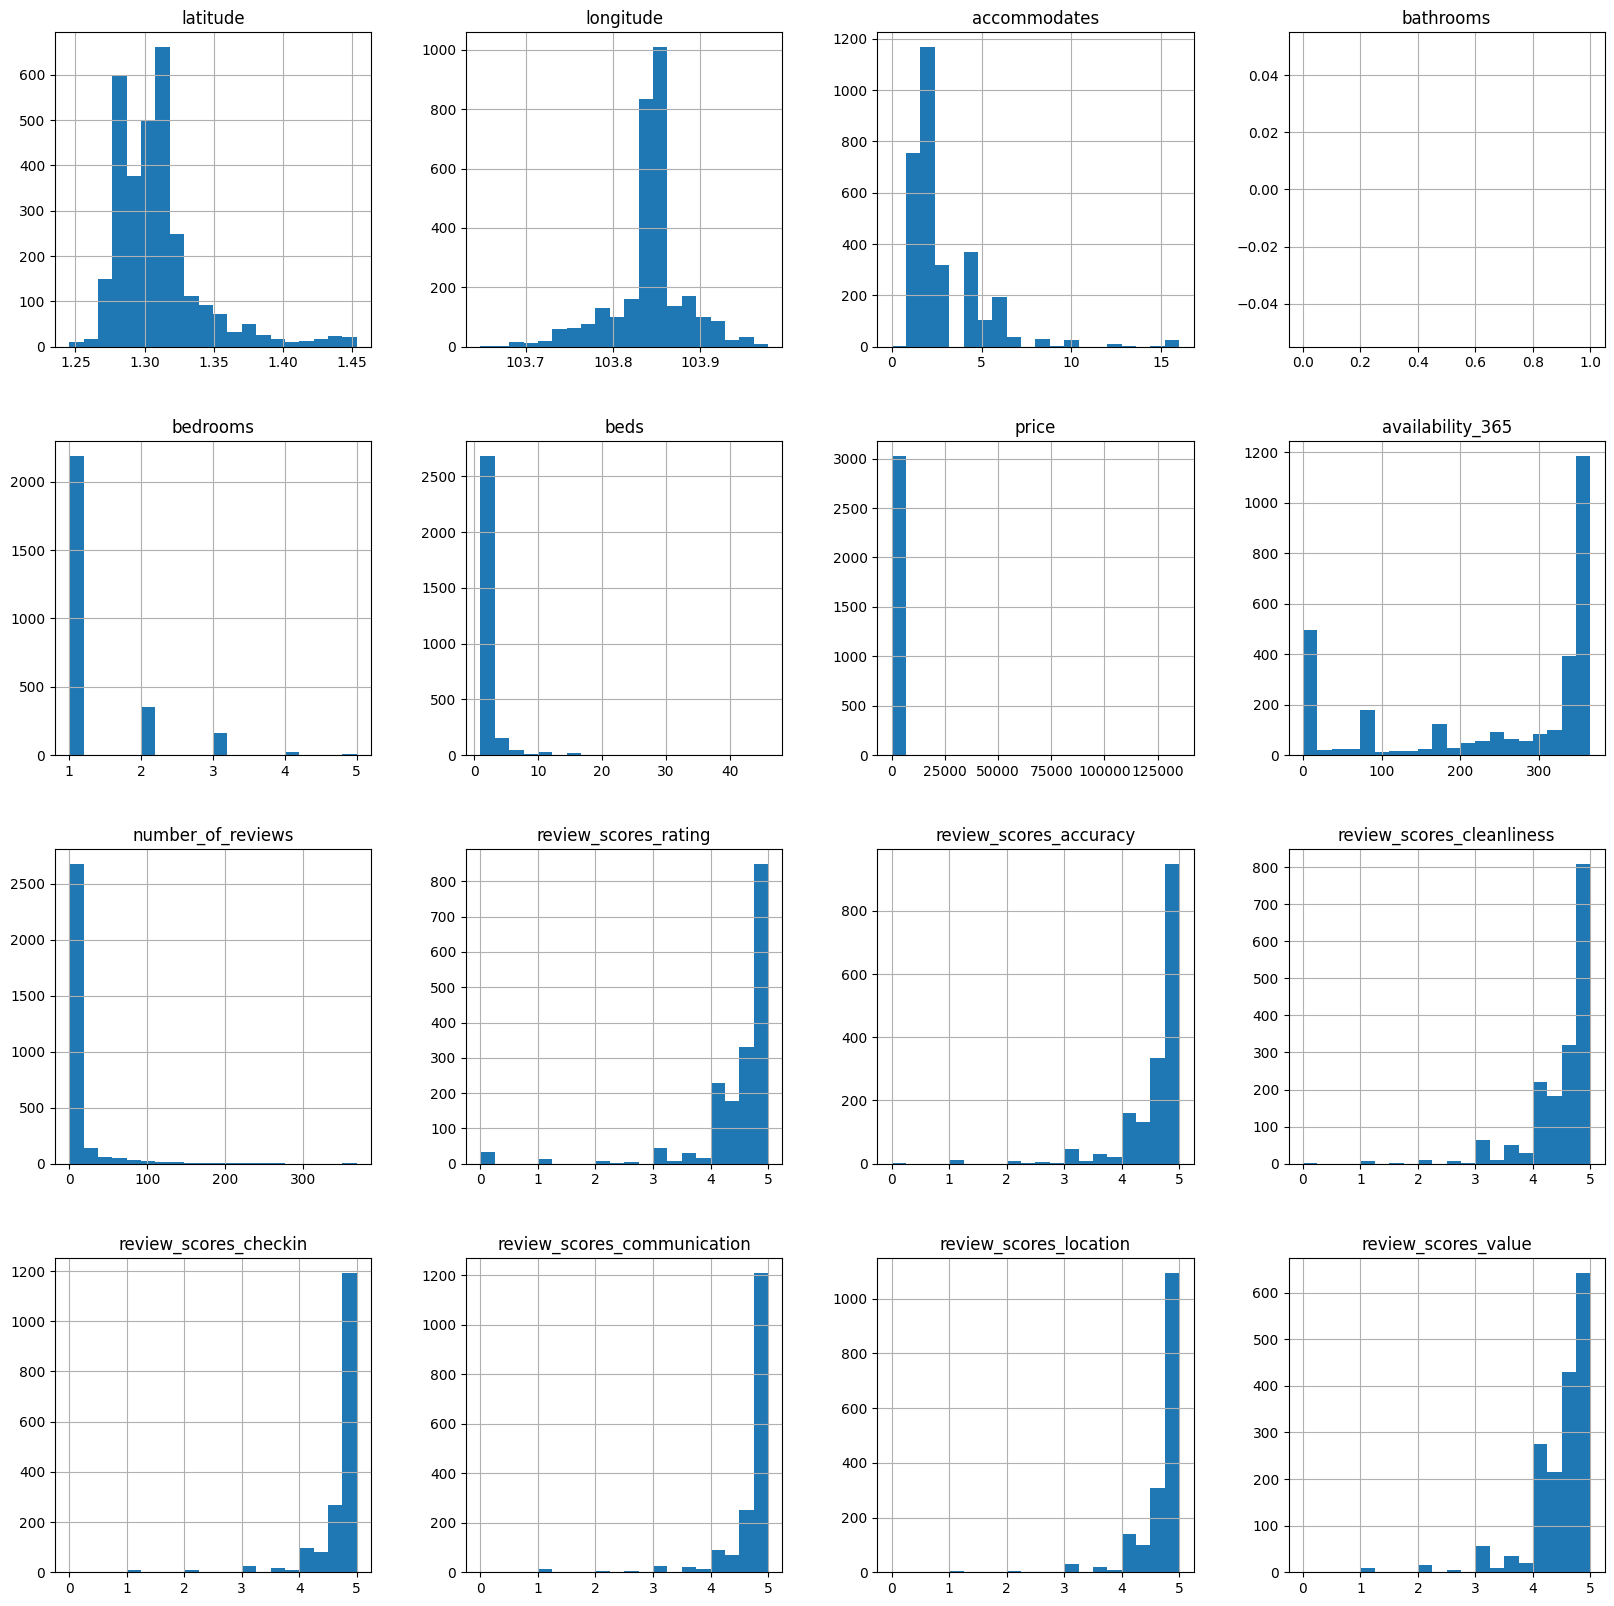

In [9]:
df.hist(figsize=(20,20), bins=20); # Represent counts of each type per data columns

### Fixing missing values (Imputer)

Missing values for bedrooms, and beds are replaced with the median. Drop Bathrooms columns as they are all empty.

In [10]:
for col in ['bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

df.drop(columns=['bathrooms'], inplace=True)

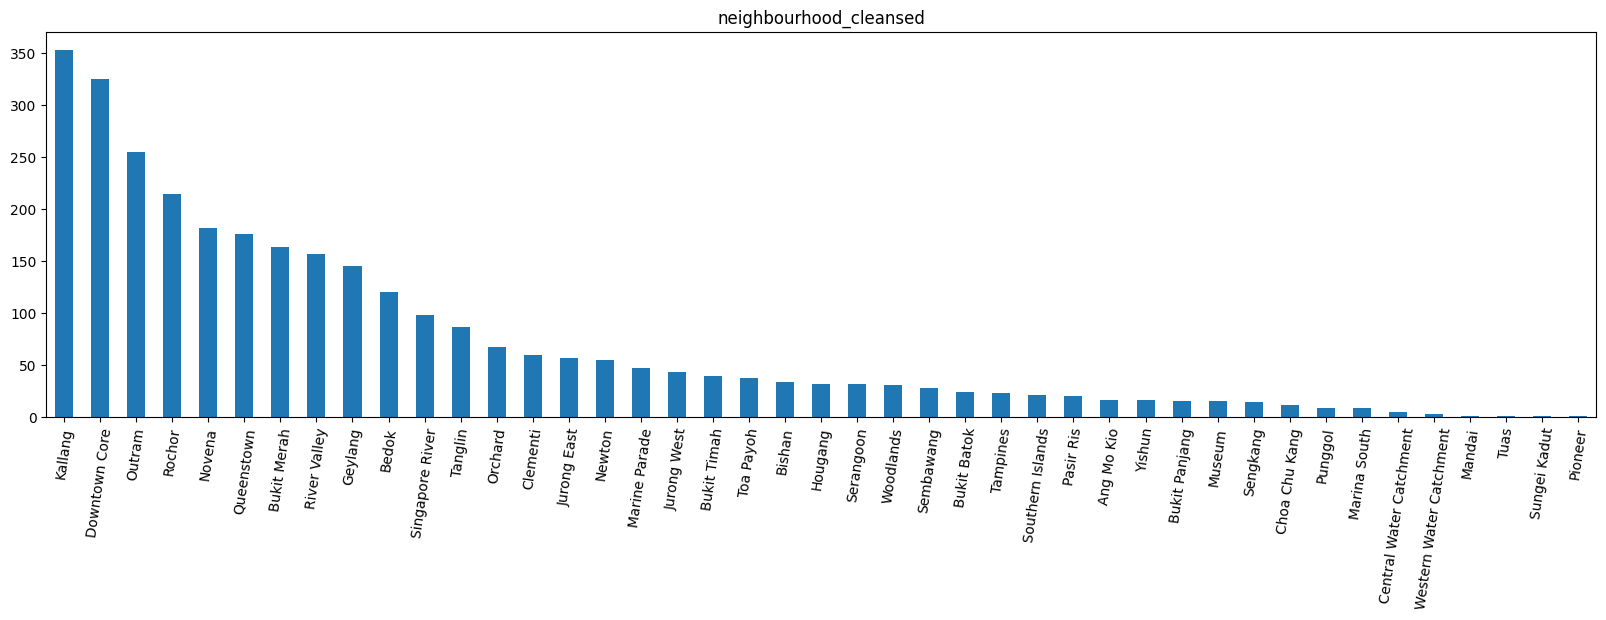

,Count,%
Kallang,353,0.116233
Downtown Core,325,0.107014
Outram,255,0.083964
Rochor,214,0.070464
Novena,182,0.059928
Queenstown,176,0.057952
Bukit Merah,163,0.053671
River Valley,157,0.051696
Geylang,145,0.047744
Bedok,120,0.039513


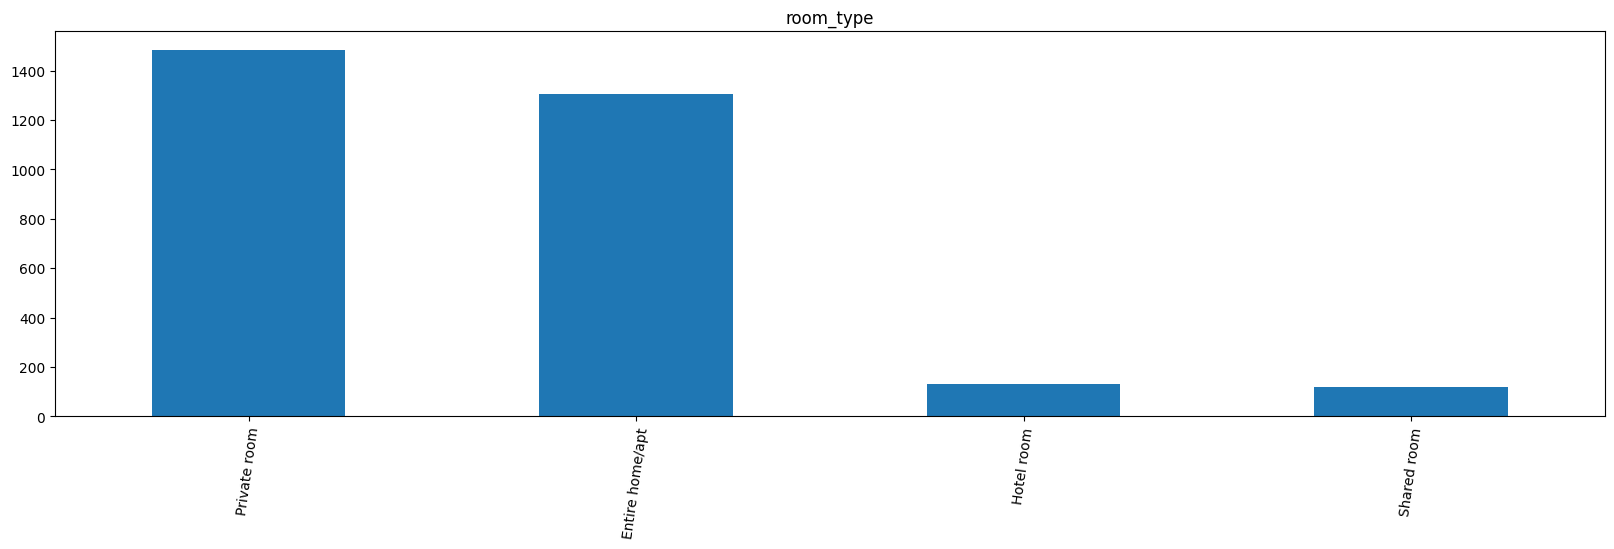

,Count,%
Private room,1485,0.488969
Entire home/apt,1306,0.430030
Hotel room,129,0.042476
Shared room,117,0.038525


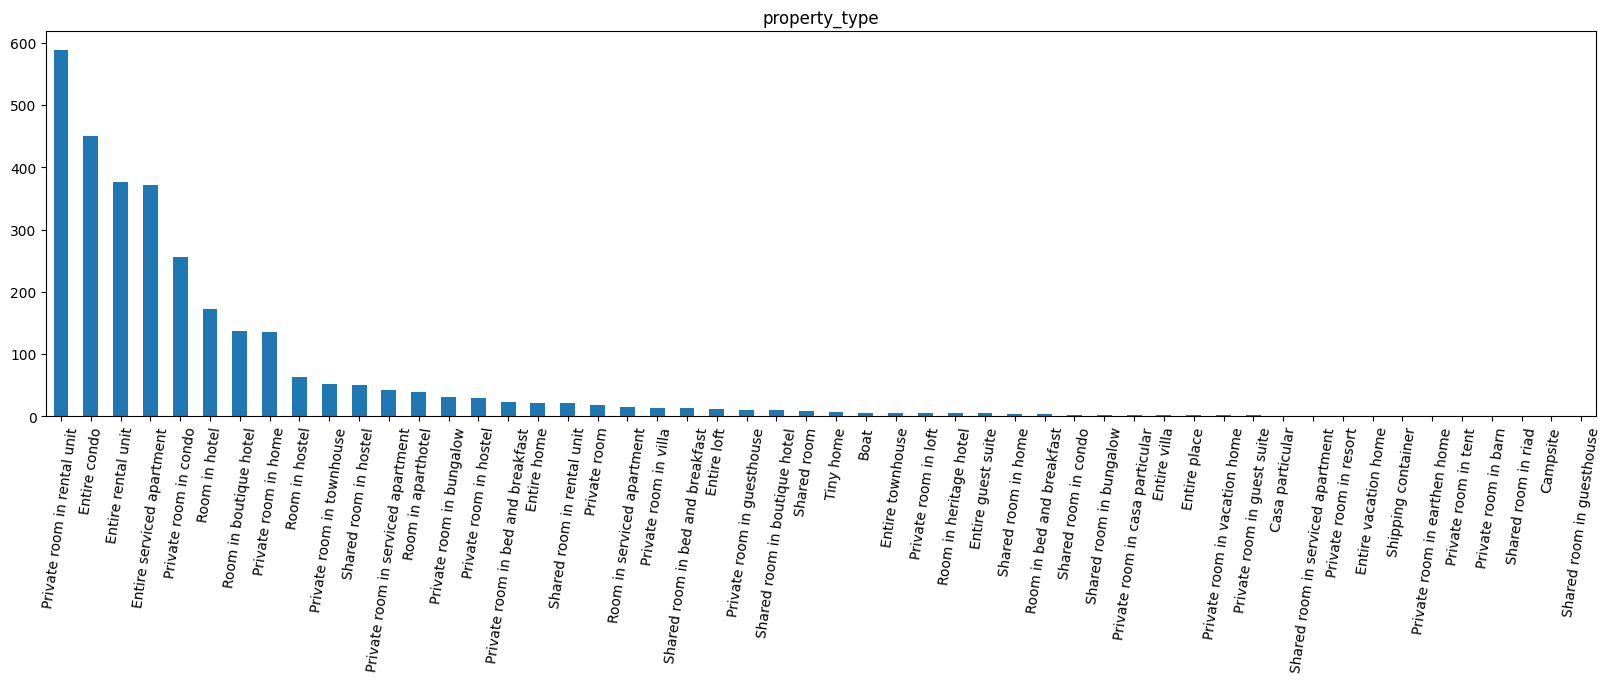

,Count,%
Private room in rental unit,589,0.193941
Entire condo,451,0.148502
Entire rental unit,377,0.124136
Entire serviced apartment,372,0.122489
Private room in condo,256,0.084294
Room in hotel,172,0.056635
Room in boutique hotel,137,0.045110
Private room in home,135,0.044452
Room in hostel,64,0.021073
Private room in townhouse,52,0.017122


In [11]:
for col in ['neighbourhood_cleansed', 'room_type', 'property_type']:
    category_count_plot(col, figsize=(20,5))
    neighbourhood_count = df[col].value_counts(normalize=False)
    neighbourhood_percent = df[col].value_counts(normalize=True)
    concatenated1 = pd.concat([neighbourhood_count,neighbourhood_percent], axis=1)
    concatenated1.columns = ['Count','%']
    display(concatenated1)

## Sort property_type to either houses, apartments or hotels

In [12]:
# Sort them to either houses, apartments or hotels
df['property_type'].replace({
    'Private room in rental unit': 'Apartment',
    'Entire condo': 'Apartment',
    'Entire rental unit': 'House',
    'Entire serviced apartment': 'Apartment',
    'Private room in condo': 'Apartment',
    'Room in hotel': 'Hotel',
    'Room in boutique hotel': 'Hotel',
    'Private room in home': 'House',
    'Room in hostel': 'Hotel',
    'Private room in townhouse': 'House',
    'Shared room in hostel': 'Hotel',
    'Private room in serviced apartment': 'Apartment',
    'Room in aparthotel': 'Hotel',
    'Private room in bungalow': 'House',
    'Private room in hostel': 'Hotel',
    'Private room in bed and breakfast': 'Hotel',
    'Entire home': 'House',
    'Shared room in rental unit': 'House'
}, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment', 'Hotel']), 'property_type'] = 'Other'

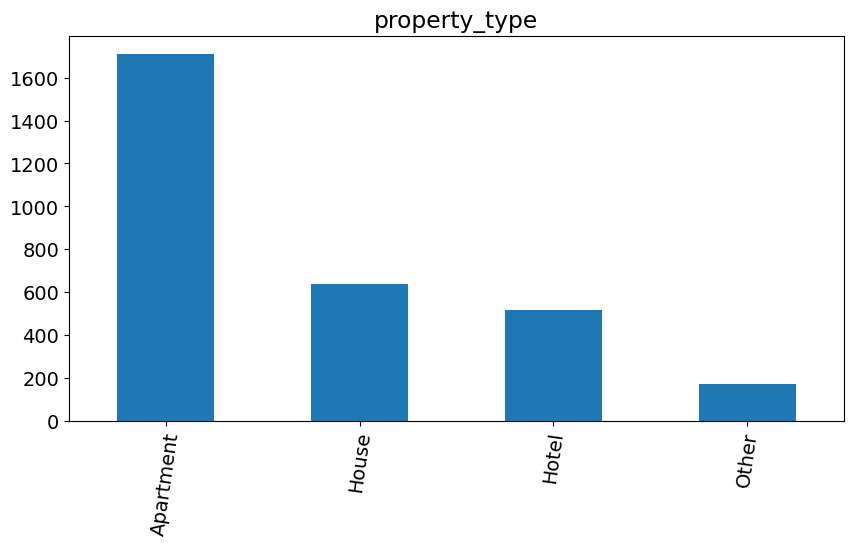

,Count,%
Apartment,1711,0.563385
House,638,0.210076
Hotel,517,0.170234
Other,171,0.056306


In [13]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = 10, 10
for col in ['property_type']:
    category_count_plot(col, figsize=(10,5))
    neighbourhood_count = df[col].value_counts(normalize=False)
    neighbourhood_percent = df[col].value_counts(normalize=True)
    concatenated2 = pd.concat([neighbourhood_count,neighbourhood_percent], axis=1)
    concatenated2.columns = ['Count','%']
    display(concatenated2)

### Change the date to year difference

In [14]:
import datetime
thisYear = datetime.date.today().year
df['host_since_years'] = thisYear - pd.DatetimeIndex(df['host_since']).year
host_since1 = df['host_since']

df.drop(columns=['host_since'], inplace=True)

host_since_years1= df['host_since_years']
concatenated3 = pd.concat([host_since1,host_since_years1], axis=1)
concatenated3.columns = ['host_since','host_since_years']
display(concatenated3)

,host_since,host_since_years
0,2011-01-29,12
1,2011-01-29,12
2,2011-01-29,12
3,2011-11-24,12
4,2011-11-24,12
...,...,...
3032,2022-10-22,1
3033,2018-05-06,5
3034,2012-04-25,11
3035,2020-04-10,3


### Replace host response rate percentage sign to numerical float

In [15]:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float') / 100.0

### Save to new csv (pre2)

In [16]:
df.to_csv('data/clean_listingpre2.csv')
df.head()

,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since_years
0,0.9,Tampines,East Region,1.34537,103.95887,Other,Private room,6,2.0,3.0,"[""Cooking basics"", ""Refrig...",46437.0,242,20,4.44,4.37,4.00,4.63,4.78,4.26,4.32,12
1,0.9,Tampines,East Region,1.34754,103.95958,House,Private room,1,1.0,1.0,"[""Cooking basics"", ""Refrig...",81.0,242,24,4.16,4.22,4.09,4.43,4.43,4.17,4.04,12
2,0.9,Tampines,East Region,1.34531,103.96100,House,Private room,2,1.0,2.0,"[""Cooking basics"", ""Heatin...",81.0,305,47,4.41,4.39,4.52,4.63,4.64,4.50,4.36,12
3,1.0,Bukit Merah,Central Region,1.29015,103.80814,Apartment,Private room,1,1.0,1.0,"[""Air conditioning"", ""Sham...",52.0,273,22,4.40,4.16,4.26,4.47,4.42,4.53,4.63,12
4,1.0,Bukit Merah,Central Region,1.28836,103.81144,Apartment,Private room,1,1.0,1.0,"[""Air conditioning"", ""Sham...",49.0,281,14,4.50,4.69,4.23,4.62,4.54,4.62,4.46,12



## Unpack amenities (One-Hot Encoding)

In [17]:
amenities_set = set()
# # Creating a set of all possible amenities
amenities_json = df.amenities.apply(json.loads)
amenities_list = ["|".join(x) for x in list(amenities_json)]

for amenities in amenities_list:
    for amenity in amenities.split(sep="|"):
        amenities_set.add(amenity)

pd.Series(list(amenities_set))

0          21" TV with premium cable
1                  Laundromat nearby
2      Limited housekeeping — weekly
3                         Shower gel
4                          Gas stove
                   ...              
444                   Window AC unit
445                   Wifi – 19 Mbps
446                    Record player
447         HDTV with standard cable
448       Singapore Brand’s  shampoo
Length: 449, dtype: object

In [18]:
unique_amenities = list(amenities_set)
# Add columns for each amenity and fill it with boolean if the amenity exists in each row.
remember_row = len(df.columns)
print(f"Before insertion {len(df.columns)} columns")
x = [pd.Series(df['amenities'].str.contains(amenity, regex=False), name=amenity) for amenity in unique_amenities]
df = pd.concat([df] + x, axis=1)
df[unique_amenities] = df[unique_amenities].fillna(0)

print(f"After insertion {len(df.columns)} columns")
df.head()

Before insertion 22 columns
After insertion 471 columns


,host_response_rate,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bedrooms,beds,amenities,price,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since_years,"21"" TV with premium cable",Laundromat nearby,Limited housekeeping — weekly,Shower gel,Gas stove,Sea view,"Shared pool - available all year, open specific hours",Trash compactor,"55"" HDTV with standard cable",Miele electric stove,Coffee maker: Nespresso,HDTV with Netflix,Stainless steel oven,Dryer,Private patio or balcony,Fast wifi – 335 Mbps,Children’s books and toys for ages 2-5 years old,Gucci conditioner,Children’s dinnerware,"70"" HDTV with Apple TV",Hot tub,Bodyshop shampoo,BBQ grill,Wifi,Outdoor furniture,Shared backyard,"43"" HDTV with Disney+, Netflix",Paid street parking off premises,Public or shared beach access,Electrolux stainless steel induction stove,Sound system with Bluetooth and aux,"Shared outdoor pool - available all year, open specific hours, infinity",Wifi – 22 Mbps,Stainless steel electric stove,"Shared outdoor pool - available all year, open specific hours",TV,24-hour fitness center,"42"" TV with standard cable","Exercise equipment: free weights, stationary bike, treadmill, yoga mat",Exercise equipment: free weights,Backyard,Dryer – In building,Dryer – In unit,"42"" HDTV with Netflix",Exercise equipment: yoga mat,Waterfront,Fresh shampoo,Subzero refrigerator,LUX body soap,Toaster,ELBA Professional stove,"Coffee maker: drip coffee maker, espresso machine, french press, Nespresso",Shared backyard – Not fully fenced,Children’s books and toys,"Coffee maker: Nespresso, pour-over coffee",Sauna,Sunsik conditioner,"Shared outdoor pool - available all year, open specific hours, olympic-sized",Fast wifi – 539 Mbps,"HDTV with Amazon Prime Video, Hulu, Netflix","Private outdoor pool - open specific hours, infinity",Essential shampoo,Coffee maker,Private backyard,Ping pong table,Private entrance,Children’s books and toys for ages 0-2 years old and 2-5 years old,Toshiba refrigerator,Pack ’n play/Travel crib,Free residential garage on premises,Clothing storage: walk-in closet and closet,Exercise equipment,Hotel Choice Brand shampoo,Shared backyard – Fully fenced,Paid washer – In building,Body soap,Shared hot tub,Le Labo body soap,Shared patio or balcony,"Clothing storage: wardrobe, closet, and dresser",Lockbox,Fast wifi – 137 Mbps,Fast wifi – 142 Mbps,Gym,Indoor fireplace: gas,Bed linens,Bidet,TV with Apple TV,Sunsilk conditioner,"32"" HDTV","HDTV with HBO Max, Apple TV, Netflix, premium cable, standard cable",Board games,Kitchenette,Outlet covers,Fast wifi – 81 Mbps,Wifi – 21 Mbps,Fire extinguisher,Miele oven,Crib - always at the listing,LUX conditioner,Free dryer – In unit,"55"" HDTV",TV with standard cable,In-House Brand body soap,Free resort access,Dedicated workspace,Samsung refrigerator,Fast wifi – 147 Mbps,Resort view,Sunsilk shampoo,Private outdoor pool - available all year,Paid dryer – In unit,ANYAH shampoo,Fast wifi – 154 Mbps,Paid parking garage on premises – 20 spaces,Bosch stove,Game console,Fast wifi – 328 Mbps,Sound system with aux,HDTV,"Exercise equipment: stationary bike, treadmill","40"" HDTV",Room-darkening shades,"Clothing storage: dresser, wardrobe, and closet",Fast wifi – 253 Mbps,Pool,"Exercise equipment: elliptical, free weights, stationary bike, treadmill",ANYAH body soap,Children’s books and toys for ages 0-2 years old,Panasonic stainless steel oven,Pack ’n play/Travel crib - available upon request,Paid parking lot off premises,Fast wifi – 345 Mbps,Paid resort access,"32"" TV with premium cable",Resort access,Coffee maker: espresso machine,Adidas body soap,Wifi – 7 Mbps,Fast wifi – 156 Mbps,Elevator,Fire pit,Free street parking,"75"" HDTV with Apple TV, Netflix, Disney+, Chromecast, HBO Max",Air conditioning,Extra pillows an

### Remove mostly empty columns (from amenities encoding)
Any column that has mostly true or mostly false values can be treated as a constant, and hence dropped.

In [19]:
# A filter to remove all columns with > 90% false values or > 90% true values (constant).
to_be_removed = []

for col in df.iloc[:, remember_row:].columns:
    if (df[col].mean() > 0.9) or (df[col].mean() < 0.1):
        to_be_removed.append(col)
display(pd.Series(to_be_removed))
print(f"Number of cols removed {len(to_be_removed)}")

df.drop(columns=to_be_removed, axis=1, inplace=True)

0          21" TV with premium cable
1                  Laundromat nearby
2      Limited housekeeping — weekly
3                          Gas stove
4                           Sea view
                   ...              
391                   Window AC unit
392                   Wifi – 19 Mbps
393                    Record player
394         HDTV with standard cable
395       Singapore Brand’s  shampoo
Length: 396, dtype: object

Number of cols removed 396


In [20]:
df.drop('amenities', axis=1, inplace=True)
print("Data type:", type(df))
print("Data dimensions: ", df.shape) 

Data type: <class 'pandas.core.frame.DataFrame'>
Data dimensions:  (3037, 74)


### Replace all the missing values with 0. The reason we are not replacing the missing values with mean/median value is because the customers might have not give their reviews because they are not satisfied with the service. 

In [21]:
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df['review_scores_rating'] = df['review_scores_rating'].fillna(0)
df['review_scores_accuracy'] = df['review_scores_accuracy'].fillna(0)
df['review_scores_cleanliness'] = df['review_scores_cleanliness'].fillna(0)
df['review_scores_checkin'] = df['review_scores_checkin'].fillna(0)
df['review_scores_communication'] = df['review_scores_communication'].fillna(0)
df['review_scores_location'] = df['review_scores_location'].fillna(0)
df['review_scores_value'] = df['review_scores_value'].fillna(0) 

df[['host_response_rate','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].head(n=3037)

,host_response_rate,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0.9,4.44,4.37,4.00,4.63,4.63,4.78,4.26,4.32
1,0.9,4.16,4.22,4.09,4.43,4.43,4.43,4.17,4.04
2,0.9,4.41,4.39,4.52,4.63,4.63,4.64,4.50,4.36
3,1.0,4.40,4.16,4.26,4.47,4.47,4.42,4.53,4.63
4,1.0,4.50,4.69,4.23,4.62,4.62,4.54,4.62,4.46
...,...,...,...,...,...,...,...,...,...
3032,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3033,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3034,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3035,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Trim outliers and $0 rental prices

In [22]:
# Remove $0 rental
df = df.query('price != 0')
# Remove outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['price'] < (Q1 - 1.5 * IQR)) | (df['price'] > (Q3 + 1.5 * IQR)))]
df[['price']].head(n=2772)

,price
1,81.0
2,81.0
3,52.0
4,49.0
5,175.0
...,...
3029,45.0
3030,45.0
3031,186.0
3034,83.0


In [23]:
print("Data type:", type(df))
print("Data dimensions: ", df.shape) 

Data type: <class 'pandas.core.frame.DataFrame'>
Data dimensions:  (2772, 74)


# Save to new csv (pre)

In [24]:
# Remove index from df then save
df.to_csv('data/clean_listingpre.csv')

## Separate all 'neighbourhood_cleansed', 'neighbourhood_group_cleansed' , 'property_type' and 'room_type' columns

In [25]:
col = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type']
df[col] = df[col].astype('category')

transformer = make_column_transformer(
    (
        OneHotEncoder(),
        make_column_selector(dtype_include="category")
     ), remainder='passthrough', verbose_feature_names_out=False)
transformed = transformer.fit_transform(df)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
df.head()

,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,neighbourhood_cleansed_Clementi,neighbourhood_cleansed_Downtown Core,neighbourhood_cleansed_Geylang,neighbourhood_cleansed_Hougang,neighbourhood_cleansed_Jurong East,neighbourhood_cleansed_Jurong West,neighbourhood_cleansed_Kallang,neighbourhood_cleansed_Mandai,neighbourhood_cleansed_Marine Parade,neighbourhood_cleansed_Museum,neighbourhood_cleansed_Newton,neighbourhood_cleansed_Novena,neighbourhood_cleansed_Orchard,neighbourhood_cleansed_Outram,neighbourhood_cleansed_Pasir Ris,neighbourhood_cleansed_Pioneer,neighbourhood_cleansed_Punggol,neighbourhood_cleansed_Queenstown,neighbourhood_cleansed_River Valley,neighbourhood_cleansed_Rochor,neighbourhood_cleansed_Sembawang,neighbourhood_cleansed_Sengkang,neighbourhood_cleansed_Serangoon,neighbourhood_cleansed_Singapore River,neighbourhood_cleansed_Southern Islands,neighbourhood_cleansed_Sungei Kadut,neighbourhood_cleansed_Tampines,neighbourhood_cleansed_Tanglin,neighbourhood_cleansed_Toa Payoh,neighbourhood_cleansed_Western Water Catchment,neighbourhood_cleansed_Woodlands,neighbourhood_cleansed_Yishun,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_response_rate,latitude,longitude,accommodates,bedrooms,beds,price,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since_years,Shower gel,Dryer,BBQ grill,TV,Private entrance,Gym,Bed linens,Fire extinguisher,TV with standard cable,Dedicated workspace,Pool,Elevator,Free street parking,Extra pillows and blankets,Bathtub,Carbon monoxide alarm,Building staff,Shampoo,Security cameras on property,Heating,Refrigerator,Clothing storage,Free parking on premises,Patio or balcony,Washer,Hangers,Paid parking on premises,Self check-in,Iron,Paid parking off premises,Pets allowed,Smoke alarm,Hot water,Cleaning available during stay,Essentials,Hot water kettle,Lock on bedroom door,Host greets you,Kitchen,Dining table,Stove,Oven,Crib,First aid kit,Coffee,Dishes and silverware,Keypad,Single level home,Luggage dropoff allowed,Hair dryer,Breakfast,Microwave,Cooking basics
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9,1.34754,103.95958,1,1.0,1.0,81.0,242,24,4.16,4.22,4.09,4.43,4.43,4.17,4.04,12,False,True,True,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,True,False,False,True,True,True,False,True,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9,1.34531,103.961,2,1.0,2.0,81.0,305,47,4.41,4.39,4.52,4.63,4.64,4.5,4.36,12,False,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,False,True,False,False,False,True,True,False,True,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True
2,0.0,0.0

### If it is true, 1.0. If it is false, 0.0. For example, separate the property_type columns will give the following table.

In [26]:
df[['property_type_Apartment','property_type_Hotel','property_type_House','property_type_Other']].head(n=len(df))

,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
2767,0.0,1.0,0.0,0.0
2768,0.0,0.0,0.0,1.0
2769,0.0,1.0,0.0,0.0
2770,1.0,0.0,0.0,0.0


# Feature Engineering

Warning: Latitude and Longitude from OpenStreetMap is randomised by maximum of 400m for anonymity. -Source: Airbnb Data Dictionary

Load point data from OpenStreetMap

In [27]:
city = gpd.read_file('data/singapore.geojson')
city.head()

,osm_id,name,ref,amenity,highway,shop,leisure,railway,other_tags,geometry
0,25451918,NaN,2A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97394 1.32757)
1,25455287,NaN,14A,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.87400 1.29544)
2,25455292,NaN,10B,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.90850 1.30101)
3,25455304,NaN,1,NaN,motorway_junction,NaN,NaN,NaN,NaN,POINT (103.97848 1.33468)
4,26778790,NaN,NaN,NaN,traffic_signals,NaN,NaN,NaN,NaN,POINT (103.85002 1.30152)


Filter out dataframe for different amenities, such as (MRT, bus stops, malls, schools, food places)

In [28]:
common_filter = lambda x: ['osm_id', 'name', 'ref', f'{x}', 'other_tags', 'geometry']

mrt = city.filter(items=common_filter('railway'))
mrt.query('railway == "station"', inplace=True)

bus = city.filter(items=common_filter('highway'))
bus.query('highway == "bus_stop"', inplace=True)

mall = city.filter(items=common_filter('shop'))
mall.query('shop == "mall"', inplace=True)

school = city.filter(items=common_filter('amenity'))
school.query('amenity == "school"', inplace=True)

food = city.filter(items=common_filter('amenity'))
food.query('amenity == "food_restaurant" | amenity == "restaurant"', inplace=True)

food.head()

,osm_id,name,ref,amenity,other_tags,geometry
1878,370791987,NaN,NaN,restaurant,NaN,POINT (103.89834 1.37508)
1963,380582666,Suki-ya,NaN,restaurant,"""addr:city""=>""Singapore"",""...",POINT (103.88548 1.35949)
6280,462263947,Jumbo Seafood,NaN,restaurant,"""addr:city""=>""Singapore"",""...",POINT (103.93068 1.30515)
6285,462264013,Jumbo Seafood Gallery,NaN,restaurant,"""cuisine""=>""asian"",""wheelc...",POINT (103.84830 1.28929)
6336,512070755,Hooters,NaN,restaurant,"""brand""=>""Hooters"",""brand:...",POINT (103.84588 1.28996)


<Axes: >

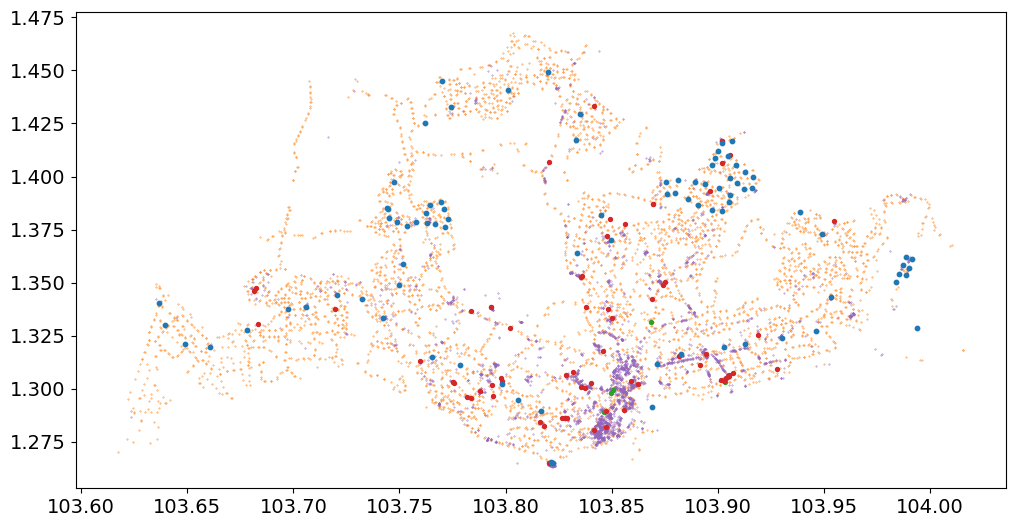

In [29]:
fig, ax = plt.subplots(figsize=(12,16))
ax.set_aspect('equal')
mrt.plot(ax=ax, legend=True, markersize = 10, zorder=10)
bus.plot(ax=ax, legend=True, markersize = 0.1, zorder=1)
mall.plot(ax=ax, legend=True, markersize = 8, zorder=3)
school.plot(ax=ax, legend=True, markersize = 8, zorder=3)
food.plot(ax=ax, legend=True, markersize = 0.1, zorder=2)

Find distance from the closest amenity

In [30]:
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].astype('float64')

In [31]:
# Creates new columns converting coordinate degrees to radians.
def degree_to_radians(data: gpd.GeoDataFrame)->None:
    if not {'latitude', 'longitude'}.issubset(data.columns):
        geometry_to_coordinates(data)
    for column in ['latitude','longitude']:
        data[column] = np.deg2rad(data[column].values)

def geometry_to_coordinates(data: gpd.GeoDataFrame)->None:
    data['longitude'] = data.geometry.x
    data['latitude'] = data.geometry.y

def find_closest(data: gpd.GeoDataFrame, name="_")->pd.Series:
    # Check if 'lat' and 'lon' exists in data and df
    if not {'latitude','longitude'}.issubset(data.columns):
        degree_to_radians(data)
    # Construct ball tree
    bT = BallTree(data[['latitude', 'longitude']].values, metric='haversine')
    # Grab the first nearest neighbour (distance only)
    distances, _ = bT.query(df[['latitude', 'longitude']].values, k=1)
    # Convert distances to km
    distances = np.squeeze(distances)
    convert_to_km = np.vectorize(lambda x: x * 6371)
    distances = convert_to_km(distances)
    return pd.Series(distances, name=name)

# Convert dataset to radians
degree_to_radians(df)

df.reset_index(inplace=True)

df = pd.concat([df, find_closest(mrt, "distance_from_MRT")], axis=1)
df = pd.concat([df, find_closest(bus, "distance_from_Bus")], axis=1)
df = pd.concat([df, find_closest(mall, "distance_from_Mall")], axis=1)
df = pd.concat([df, find_closest(school, "distance_from_School")], axis=1)
df = pd.concat([df, find_closest(food, "distance_from_Food")], axis=1)

# Back to degrees
for column in ['latitude', 'longitude']:
    df[column] = np.rad2deg(df[column].values)

df.head(n=len(df))



,index,neighbourhood_cleansed_Ang Mo Kio,neighbourhood_cleansed_Bedok,neighbourhood_cleansed_Bishan,neighbourhood_cleansed_Bukit Batok,neighbourhood_cleansed_Bukit Merah,neighbourhood_cleansed_Bukit Panjang,neighbourhood_cleansed_Bukit Timah,neighbourhood_cleansed_Central Water Catchment,neighbourhood_cleansed_Choa Chu Kang,neighbourhood_cleansed_Clementi,neighbourhood_cleansed_Downtown Core,neighbourhood_cleansed_Geylang,neighbourhood_cleansed_Hougang,neighbourhood_cleansed_Jurong East,neighbourhood_cleansed_Jurong West,neighbourhood_cleansed_Kallang,neighbourhood_cleansed_Mandai,neighbourhood_cleansed_Marine Parade,neighbourhood_cleansed_Museum,neighbourhood_cleansed_Newton,neighbourhood_cleansed_Novena,neighbourhood_cleansed_Orchard,neighbourhood_cleansed_Outram,neighbourhood_cleansed_Pasir Ris,neighbourhood_cleansed_Pioneer,neighbourhood_cleansed_Punggol,neighbourhood_cleansed_Queenstown,neighbourhood_cleansed_River Valley,neighbourhood_cleansed_Rochor,neighbourhood_cleansed_Sembawang,neighbourhood_cleansed_Sengkang,neighbourhood_cleansed_Serangoon,neighbourhood_cleansed_Singapore River,neighbourhood_cleansed_Southern Islands,neighbourhood_cleansed_Sungei Kadut,neighbourhood_cleansed_Tampines,neighbourhood_cleansed_Tanglin,neighbourhood_cleansed_Toa Payoh,neighbourhood_cleansed_Western Water Catchment,neighbourhood_cleansed_Woodlands,neighbourhood_cleansed_Yishun,neighbourhood_group_cleansed_Central Region,neighbourhood_group_cleansed_East Region,neighbourhood_group_cleansed_North Region,neighbourhood_group_cleansed_North-East Region,neighbourhood_group_cleansed_West Region,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_response_rate,latitude,longitude,accommodates,bedrooms,beds,price,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,host_since_years,Shower gel,Dryer,BBQ grill,TV,Private entrance,Gym,Bed linens,Fire extinguisher,TV with standard cable,Dedicated workspace,Pool,Elevator,Free street parking,Extra pillows and blankets,Bathtub,Carbon monoxide alarm,Building staff,Shampoo,Security cameras on property,Heating,Refrigerator,Clothing storage,Free parking on premises,Patio or balcony,Washer,Hangers,Paid parking on premises,Self check-in,Iron,Paid parking off premises,Pets allowed,Smoke alarm,Hot water,Cleaning available during stay,Essentials,Hot water kettle,Lock on bedroom door,Host greets you,Kitchen,Dining table,Stove,Oven,Crib,First aid kit,Coffee,Dishes and silverware,Keypad,Single level home,Luggage dropoff allowed,Hair dryer,Breakfast,Microwave,Cooking basics,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9,1.347540,103.959580,1,1.0,1.0,81.0,242,24,4.16,4.22,4.09,4.43,4.43,4.17,4.04,12,False,True,True,True,True,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,True,False,True,False,True,False,True,True,False,False,True,True,True,False,True,False,True,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,True,0.842953,0.180102,7.976199,3.515767,0.785094
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.9,1.345310,103.961000,2,1.0,2.0,81.0,305,47,4.41,4.39,4.52,4.63,4.64,4.5,4.36,12,False,True,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,True,False,False

The resulting GeoDataFrame contains additional columns with distances to the nearest MRT station, bus stop, shopping mall, school, and food establishment, in kilometers.

In [32]:
print("Data type:", type(df))
print("Data dimensions: ", df.shape) 

Data type: <class 'pandas.core.frame.DataFrame'>
Data dimensions:  (2772, 130)


In [33]:
df.columns

Index(['index', 'neighbourhood_cleansed_Ang Mo Kio',
       'neighbourhood_cleansed_Bedok', 'neighbourhood_cleansed_Bishan',
       'neighbourhood_cleansed_Bukit Batok',
       'neighbourhood_cleansed_Bukit Merah',
       'neighbourhood_cleansed_Bukit Panjang',
       'neighbourhood_cleansed_Bukit Timah',
       'neighbourhood_cleansed_Central Water Catchment',
       'neighbourhood_cleansed_Choa Chu Kang',
       ...
       'Luggage dropoff allowed', 'Hair dryer', 'Breakfast', 'Microwave',
       'Cooking basics', 'distance_from_MRT', 'distance_from_Bus',
       'distance_from_Mall', 'distance_from_School', 'distance_from_Food'],
      dtype='object', length=130)

# Save to new csv

In [34]:
# Remove index from df then save
df.drop(['index'], axis=1, inplace=True)
df.to_csv('data/clean_listing.csv')